In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install monai==1.3.0 nibabel SimpleITK scikit-learn pandas matplotlib
!pip install itk
!pip install -q monai[itk] Si

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.4 MB/s eta 0:00:00
  Attempting uninstall

In [ ]:
!ls /content/drive/MyDrive/

'1. Microprocessor complete class note (1).pdf'
'1. Microprocessor complete class note.pdf'
'Ai ut solution.pdf'
'Auto_CatalystReport 1.pdf'
'Capacitor pdf manual.pdf'
 Classroom
'Colab Notebooks'
'Compressed Compressed Ai assessment solu (1).pdf'
'Compressed Compressed Ai assessment solu.pdf'
'edc set 020324.pdf'
'F05-1-Product Backlog Jestate Client-A Real State System V2.0.gsheet'
 lab-Report1.docx
 Labsheet0.docx
 Labsheet0.gdoc
 labsheet2_false_position.docx
 labsheet3_newton_rhapson.docx
 labsheet4_secant_method.docx
 labsheet5_Gauss_method.docx
 labsheet6gauss_seidel.docx
'microprocessor ioe full note-tuts by er. hari aryaल.pdf'
 nnUNet_data
 OStutorial.pdf
'programming for everybody(Python).pdf'
 prostate_project
 tutorial-4.pdf


In [ ]:
!pip install SimpleITK

In [ ]:
import os, time
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm

In [ ]:
 # 1.Paths
project_root = "/content/drive/MyDrive/prostate_project"
images_dir = os.path.join(project_root, "mri_images")
clinical_data_path = os.path.join(project_root, "marksheet.csv")
clinical_data_dir = os.path.dirname(clinical_data_path)

# Wait for Google Drive to mount
print(f"Checking if directory exists: {clinical_data_dir}")
max_wait_time = 30
wait_interval = 5
elapsed_time = 0

while not os.path.exists(clinical_data_dir) and elapsed_time < max_wait_time:
    print(f"Waiting for Google Drive mount... {elapsed_time}/{max_wait_time} sec")
    time.sleep(wait_interval)
    elapsed_time += wait_interval

if not os.path.exists(clinical_data_dir):
    raise RuntimeError(f"Google Drive directory not found: {clinical_data_dir}")

# 2. Load clinical data
clinical_df = pd.read_csv(clinical_data_path)
clinical_df['case_csPCa'] = clinical_df['case_csPCa'].map({'YES': 1.0, 'NO': 0.0})


Checking if directory exists: /content/drive/MyDrive/prostate_project


In [ ]:
# 3. Build data list
data_list = []
for _, row in clinical_df.iterrows():
    pid = str(row["patient_id"])
    folder = os.path.join(images_dir, pid)
    if not os.path.exists(folder): continue

    all_files = os.listdir(folder)
    t2w = [f for f in all_files if "t2w" in f.lower()]
    if not t2w: continue
    t2w_path = os.path.join(folder, t2w[0])

    if os.path.exists(t2w_path):
        data_list.append({"t2w": t2w_path, "label": row["case_csPCa"]})

print(f"Usable samples: {len(data_list)}")

# Split train and test sets

if data_list:
    train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42, stratify=[d["label"] for d in data_list])
    print(f"Train: {len(train_data)} | Test: {len(test_data)}")

Usable samples: 1500
Train: 1200 | Test: 300


In [ ]:
# Train-test split
train_data, test_data = train_test_split(
    data_list,
    test_size=0.2,
    stratify=[d["label"] for d in data_list],
    random_state=42
)

In [ ]:
# 4. Load .mha images
def load_middle_slice(path):
    img = sitk.ReadImage(path)
    array = sitk.GetArrayFromImage(img)
    mid_slice = array[array.shape[0] // 2]
    return mid_slice.astype(np.float32)

In [ ]:
# 5. Dataset class
class ProstateMRIDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = load_middle_slice(item["t2w"])
        image = np.expand_dims(image, axis=-1)
        image = np.repeat(image, 3, axis=-1)
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(item["label"], dtype=torch.long)
        return image, label

In [ ]:
# 6. Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

train_dataset = ProstateMRIDataset(train_data, transform)
test_dataset = ProstateMRIDataset(test_data, transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

In [ ]:
# 7. ResNet18 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
model.train()
epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {running_loss / len(train_loader):.4f}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 98.9MB/s]
Epoch 1: 100%|██████████| 150/150 [31:39<00:00, 12.66s/it]


Epoch 1 Loss: 0.6352


Epoch 2: 100%|██████████| 150/150 [10:22<00:00,  4.15s/it]


Epoch 2 Loss: 0.3855


Epoch 3: 100%|██████████| 150/150 [10:24<00:00,  4.16s/it]


Epoch 3 Loss: 0.2340


Epoch 4: 100%|██████████| 150/150 [10:22<00:00,  4.15s/it]


Epoch 4 Loss: 0.1738


Epoch 5: 100%|██████████| 150/150 [10:27<00:00,  4.18s/it]


Epoch 5 Loss: 0.1319


Epoch 6: 100%|██████████| 150/150 [10:27<00:00,  4.18s/it]


Epoch 6 Loss: 0.1128


Epoch 7: 100%|██████████| 150/150 [10:26<00:00,  4.18s/it]


Epoch 7 Loss: 0.0731


Epoch 8: 100%|██████████| 150/150 [10:31<00:00,  4.21s/it]


Epoch 8 Loss: 0.0803


Epoch 9: 100%|██████████| 150/150 [10:29<00:00,  4.20s/it]


Epoch 9 Loss: 0.0658


Epoch 10: 100%|██████████| 150/150 [10:34<00:00,  4.23s/it]

Epoch 10 Loss: 0.0901


Test Accuracy: 0.6267


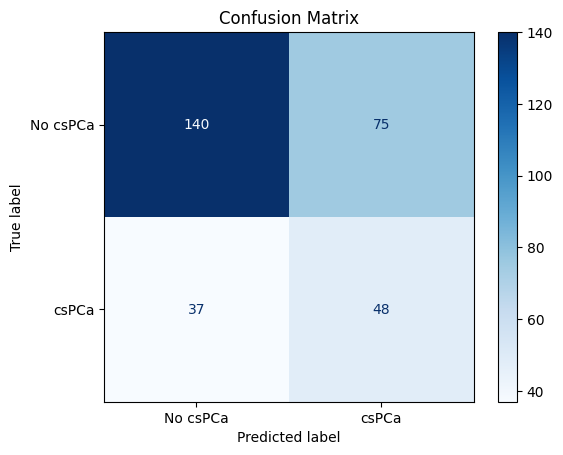


Model evaluation finished.


In [ ]:
# 8. Evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)
print(f"Test Accuracy: {acc:.4f}")

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(
  confusion_matrix=cm,
  display_labels=["No csPCa", "csPCa"]
  )
disp.plot(cmap="Blues")
plt.title('Confusion Matrix')
plt.show()

print("\nModel evaluation finished.")

#runcode from star to print the cm

# ConfusionMatrixDisplay(cm).plot()
# plt.title("Confusion Matrix")
# plt.show()